In [11]:
import pandas as pd
import missingno as msno
import seaborn as sns
from datetime import datetime
import datetime as dt
df_migration_pre = pd.read_csv("dataset_migration.csv")
df_hdi_pre = pd.read_csv("HDI_Index.csv")

In [12]:
#Función para convertir año [date_type] a número ordinal
def dateto_ordinal(df,date_column):
    #Función para convertir fecha a tipo ordinal
    df['Fecha_Numerico']=df[date_column].map(dt.datetime.toordinal)
    return df

#Función para convertir año [str_type] a número ordinal
def convert_year_to_ordinal(year_input):
    year_num = datetime.strptime(year_input,'%Y').toordinal()
    return year_num

def country_code_num(df):
    #Funcion para crear diccionario codigo pais y "label_encoder"
    country_code = df["Country Code"].unique()
    country_code = country_code.tolist()
    country_code_c = {}
    keys = country_code
    values = range(1, len(keys)+1)
    for key, value in zip(keys, values):
        country_code_c[key] = value
    #Add new column Country_code_num
    df["country_code_c"] = df["Country Code"].map(country_code_c)
    #Funcion para crear diccionario id pais y "label_encoder"
    num_country_code = {v: k for k, v in country_code_c.items()}
    return df

def clearna (df):
    #Funcion para eliminar registros nulos
    df.dropna(inplace=True)
    return df

def dropcolumns_for_ml(df):
    #Funcion para dejar columnas de tipo float para el modelo de ml
    df = df.drop(["Country Code","Year","Unemployment Advanced Education (%)","Unemployment Intermediate Education (%)", "Unemployment Basic Education (%)","Labor Taxes and Contributions (%)","Social Protection and Labor Programs (%)","Poverty Rate (%)"],axis=1)
    return df

def dropcolumns(df):
    #Funcion para eliminar columnas
    df = df.drop(["Unemployment Advanced Education (%)","Unemployment Intermediate Education (%)", "Unemployment Basic Education (%)","Labor Taxes and Contributions (%)","Social Protection and Labor Programs (%)","Poverty Rate (%)"],axis=1)
    return df

def preprodata(df_migration,df_hdi):
    #Funcion para preprocesamiento de datos
    #unir dataframes
    df = df_migration.merge(df_hdi, how="left", on=["Country Name", "Country Code", "Year"])
    #eliminar columnas redundanes o que no tienen importancia en el modelo
    df.drop(["Unnamed: 0_x","Unnamed: 0_y"], axis= 1, inplace=True)
    df.drop("PIB Growth (%)", axis= 1, inplace=True)
    #Convertir year as date
    df["Year"] = pd.to_datetime(df["Year"].astype(str),format= "%Y")
    df= dateto_ordinal(df,"Year")
    df = country_code_num(df)
    df_ml = df
    df = dropcolumns(df)
    df = clearna(df)
    df_ml = dropcolumns_for_ml(df_ml)
    df_ml = clearna(df_ml)
    return df_ml , df

def country_reduce(df,list_country):
    mask = df["Country Name"].isin(list_country)
    df_filtered = df[mask]
    return df_filtered

In [13]:
#Lista de paises para el modelo ML paises receptores y emisores en conjunto
country_list =['Afganistán','Francia','China','Canadá','India','España',
                'México','Alemania','Venezuela','Italia','Pakistán','Estados Unidos',
               'Ucrania','Arabia Saudita','Bangladesh','Australia','República Árabe Siria',	
               'Reino Unido','Yemen, Rep. del','Federación de Rusia']
#country_list = ['Estados Unidos'] 

#Ejecución función de preprocesamiento
dfm_total_ml, dfm_total = preprodata(df_migration_pre,df_hdi_pre)
dfm_ml = country_reduce(dfm_total_ml,country_list)
dfm_total = country_reduce(dfm_total,country_list)

<AxesSubplot:>

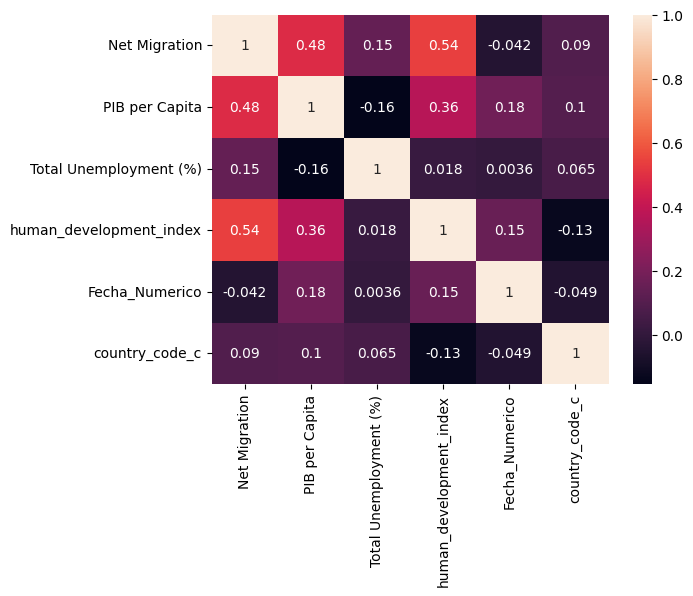

In [14]:
#Heat Map
corr = dfm_ml.drop(["Country Name"],axis=1).corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,annot=True)

In [15]:
#Función para ejecutar escalado modelo no supervisado
def func_scaler(df):
    #Escalar X
    X_in = df.drop(["Country Name","Net Migration"],axis=1).values
    #Escalado de todos los features Min_Max scaler
    # Import MinMaxScaler
    from sklearn.preprocessing import MinMaxScaler
    # Instantiate MinMaxScaler
    MM_scaler = MinMaxScaler()
    # Fit MM_scaler to the data
    MM_scaler.fit(X_in)
    #Escalado de todos los features Min_Max scaler
    X = MM_scaler.transform(X_in)
    return MM_scaler

def regresion_lineal (df,MM_scaler_in):
    # Importamos el módulo que contiene el algorimto de regresión lineal
    from sklearn.linear_model import LinearRegression 
    # Importar MinMaxScaler para escalar los features
    from sklearn.preprocessing import MinMaxScaler
    #Importar Biblioteca para graficar 
    import matplotlib.pyplot as plt 
    #Importar función para calcular el Mean squared error
    from sklearn.metrics import mean_squared_error

    #Separar para hacer escaldo
    X = df.drop(["Country Name","Net Migration"],axis=1).values
    y = df["Net Migration"].values

    #Se separan en train y test set
    X_train = df[(df.Fecha_Numerico>=730120)&(df.Fecha_Numerico<733733)]
    X_train = X_train.drop(["Country Name","Net Migration"],axis=1).values 
    y_train = df[(df.Fecha_Numerico>=730120)&(df.Fecha_Numerico<733733)]["Net Migration"].values

    X_test = df[(df.Fecha_Numerico>=733733)&(df.Fecha_Numerico<= 737425)]
    X_test = X_test.drop(["Country Name","Net Migration"],axis=1).values
    y_test = df[(df.Fecha_Numerico>=733733)&(df.Fecha_Numerico<=737425)]["Net Migration"].values

    MM_scaler = MM_scaler_in

    #Escalado de todos los features Min_Max scaler
    X_train= MM_scaler.transform(X_train)
    X_test = MM_scaler.transform(X_test)

    # Instanciamos un objeto de la clase LinearRegression. Aquí estamos creando nuestro modelo predictivo 'linear_model'
    linear_model = LinearRegression() 

    # Entrenamos el modelo
    linear_model.fit(X_train, y_train)

    #Hacemos las predicciones
    y_train_pred = linear_model.predict(X_train)
    y_test_pred = linear_model.predict(X_test)

    # Print R^2 
    print('El coeficiente de determinación es:', linear_model.score(X_train, y_train))
    print('Error en datos de train:', mean_squared_error(y_train_pred, y_train))
    print('Error en datos de test:', mean_squared_error(y_test, y_test_pred))
    return linear_model

#Ejecutar función escldo-Ejecutar Función regresión
MM_scaler_func = func_scaler(dfm_ml)
model = regresion_lineal(dfm_ml,MM_scaler_func)

El coeficiente de determinación es: 0.5299243460219341
Error en datos de train: 99685620197.65294
Error en datos de test: 186478140986.95438


In [16]:
dfm_total[(dfm_total["Country Name"] == 'Estados Unidos') & (dfm_total["Fecha_Numerico"] == 733773)]


,Country Name,Country Code,Year,Net Migration,PIB per Capita,Total Unemployment (%),human_development_index,Fecha_Numerico,country_code_c
2373,Estados Unidos,USA,2010-01-01,1030731.0,1.504896e+13,9.63,0.911,733773,204


In [17]:
#Generando predicción 

#Función predicción
def func_prediction(country_in,year_in,model_in,MM_scaler_in):
    year=year_in
    year_num = convert_year_to_ordinal(year)
    country=country_in
    PIB_per_Capita = 1.504896e+13
    Total_Unemployment = 9.63
    human_development_index = 0.911
    country_code_c = 204

    diccionario_input = {"PIB per Capita":PIB_per_Capita,
                    "Total Unemployment (%)":Total_Unemployment,
                    "human_development_index": human_development_index,
                    "Fecha_Numerico":year_num,
                    "country_code_c":country_code_c,
                    }

    MM_scaler = MM_scaler_in

    df_input = pd.DataFrame([diccionario_input])
    X_new = MM_scaler.transform(df_input.values)
    model = model_in

    prediction  = model.predict(X_new)
    print('La cantidad que se predice para migración es :' + str(round(prediction[0],2)))
    return prediction

#Llamar función predicción-Datos para Estados Unidos 2010
func_prediction("Estados Unidos","2010",model,MM_scaler_func)

La cantidad que se predice para migración es :1273968.18


array([1273968.17927463])

In [20]:
#Calculo correlaciones 4 clusters
df_4 = pd.read_csv("df_group_4.csv")
df_4.labels.value_counts()
country_4 = df_4.groupby("labels")["Country Name"].unique()
print(country_4.info)

<bound method Series.info of labels
0    [Arabia Saudita, México, Pakistán, República Á...
1               [China, India, Bangladesh, Afganistán]
2    [Australia, Canadá, España, China, Alemania, R...
3                                     [Estados Unidos]
Name: Country Name, dtype: object>


In [21]:
#Regresion lineal para todos loas años
country_list_1 = ['Federación de Rusia','Arabia Saudita','Ucrania','República Árabe Siria','Pakistán','México','Yemen, Rep. del','Venezuela']
country_list_2 = ['India','Bangladesh','Afganistán']
country_list_3 = ['Reino Unido','Francia','Italia','Canadá','España','Australia','Alemania','China']
country_list_4 = ['Estados Unidos']

df_4.drop("labels",axis=1,inplace=True)
df_4_1 = country_reduce(df_4,country_list_1)
df_4_2 = country_reduce(df_4,country_list_2)
df_4_3 = country_reduce(df_4,country_list_3)
df_4_4 = country_reduce(df_4,country_list_4) 

#Ejecutar función escldo-Ejecutar Función regresión
MM_scaler_4_1 = func_scaler(df_4_1)
model_4_1 = regresion_lineal(df_4_1,MM_scaler_4_1)

#Ejecutar función escldo-Ejecutar Función regresión
MM_scaler_4_2 = func_scaler(df_4_2)
model_4_2 = regresion_lineal(df_4_2,MM_scaler_4_2)

#Ejecutar función escldo-Ejecutar Función regresión
MM_scaler_4_3 = func_scaler(df_4_3)
model_4_3 = regresion_lineal(df_4_3,MM_scaler_4_3)

#Ejecutar función escldo-Ejecutar Función regresión
MM_scaler_4_4= func_scaler(df_4_4)
model_4_4 = regresion_lineal(df_4_4,MM_scaler_4_4)

El coeficiente de determinación es: 0.22935187472705476
Error en datos de train: 80935191479.28809
Error en datos de test: 330506936663.7495
El coeficiente de determinación es: 0.7167435903477105
Error en datos de train: 80263311243.76164
Error en datos de test: 1721227522270.1672
El coeficiente de determinación es: 0.7392604918051953
Error en datos de train: 20990042879.051598
Error en datos de test: 253195532470.1877
El coeficiente de determinación es: 0.8584385188714039
Error en datos de train: 2359662135.541333
Error en datos de test: 2199886630806.6836


In [22]:
#Llamar función predicción-Datos para Estados Unidos 2010
func_prediction("Estados Unidos","2010",model_4_4,MM_scaler_4_4)

La cantidad que se predice para migración es :1042336.58


array([1042336.5792982])

In [23]:
#Regresion lineal para todos las años
country_list_1 = ['India','Bangladesh','Pakistán','México','Venezuela']
country_list_2 = ['Afganistán','Yemen, Rep. del']
country_list_3 = ['Francia','Italia','Canadá','España']
country_list_4 = ['Estados Unidos']
country_list_5 = ['Federación de Rusia','Arabia Saudita','Ucrania','República Árabe Siria']
country_list_6 = ['Reino Unido','Australia','Alemania','China']

df_4_1 = country_reduce(df_4,country_list_1)
df_4_2 = country_reduce(df_4,country_list_2)
df_4_3 = country_reduce(df_4,country_list_3)
df_4_4 = country_reduce(df_4,country_list_4) 
df_4_5 = country_reduce(df_4,country_list_5) 
df_4_6 = country_reduce(df_4,country_list_6) 

#Ejecutar función escldo-Ejecutar Función regresión
MM_scaler_4_1 = func_scaler(df_4_1)
model_4_1 = regresion_lineal(df_4_1,MM_scaler_4_1)

#Ejecutar función escldo-Ejecutar Función regresión
MM_scaler_4_2 = func_scaler(df_4_2)
model_4_2 = regresion_lineal(df_4_2,MM_scaler_4_2)

#Ejecutar función escldo-Ejecutar Función regresión
MM_scaler_4_3 = func_scaler(df_4_3)
model_4_3 = regresion_lineal(df_4_3,MM_scaler_4_3)

#Ejecutar función escldo-Ejecutar Función regresión
MM_scaler_4_4= func_scaler(df_4_4)
model_4_4 = regresion_lineal(df_4_4,MM_scaler_4_4)

#Ejecutar función escldo-Ejecutar Función regresión
MM_scaler_4_5= func_scaler(df_4_5)
model_4_5 = regresion_lineal(df_4_5,MM_scaler_4_5)

#Ejecutar función escldo-Ejecutar Función regresión
MM_scaler_4_6= func_scaler(df_4_6)
model_4_6 = regresion_lineal(df_4_6,MM_scaler_4_6)

El coeficiente de determinación es: 0.5423423398888242
Error en datos de train: 64931496953.395294
Error en datos de test: 770843859257.9568
El coeficiente de determinación es: 0.6145747232679777
Error en datos de train: 64866156953.4066
Error en datos de test: 14706553477580.26
El coeficiente de determinación es: 0.6144611151552146
Error en datos de train: 15230651733.534077
Error en datos de test: 264479705291.19397
El coeficiente de determinación es: 0.8584385188714039
Error en datos de train: 2359662135.541333
Error en datos de test: 2199886630806.6836
El coeficiente de determinación es: 0.37432554650587047
Error en datos de train: 38625545492.78504
Error en datos de test: 450620130988.70996
El coeficiente de determinación es: 0.9864735609894638
Error en datos de train: 1141176990.6854584
Error en datos de test: 38832387502.07929
